In [1]:
import pandas as pd #pandas library
from pandas_datareader import data #data readers (google, html, etc.)
#The following line ensures that graphs are rendered in the notebook (and not in another window)
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt #Plotting library
from datetime import datetime, timedelta
import math
import re


C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data=pd.read_csv("matala2_cosmetics_2019-Nov.csv")
data=data.copy()

data["event_time"]=data['event_time'].apply(lambda x:datetime.strptime(x,"%Y-%m-%d %H:%M:%S UTC"))  #set date to datetime format

<ipython-input-2-f6e630c97fa6>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("matala2_cosmetics_2019-Nov.csv")


## Question 1

In [12]:
#answer 1

data["duration_to_next_event"]=data.groupby(["user_id"])["event_time"].diff()
data["shifted"]=data.groupby(["user_session"])["duration_to_next_event"].shift(-1)
data["duration_to_next_event"]=data["shifted"]
data.drop("shifted", axis="columns",inplace=True)
data["duration_to_next_event"]=np.where(data["duration_to_next_event"].isnull(),data["duration_to_next_event"].fillna(pd.Timedelta(0)),data["duration_to_next_event"])
data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,index_in_funnel
0,2019-11-04 15:28:57,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,0 days 00:00:00,1,1
1,2019-11-19 09:56:09,view,5711145,1487580005008409427,NaN,f.o.x,6.03,1458813,b16644a2-44db-4650-8156-f6f03782d432,0 days 00:00:00,1,1
2,2019-11-19 11:14:48,view,5814066,1487580005855658874,NaN,grattol,2.30,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,0 days 00:00:00,1,2
3,2019-11-20 11:58:06,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,0 days 00:00:21,1,3
4,2019-11-20 11:58:27,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,0 days 00:01:12,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4635832,2019-11-30 23:56:14,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:03,1,1
4635833,2019-11-30 23:56:17,view,5900651,1487580013950664926,NaN,NaN,19.52,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:04,1,1
4635834,2019-11-30 23:56:21,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:00,1,1
4635835,2019-11-30 23:56:46,view,5790563,1487580008263189483,NaN,NaN,7.14,579968937,878af093-7570-48ae-966c-d50ce61e390c,0 days 00:00:00,1,1


## Question 2

In [13]:
#answer2
data=data.sort_values(["user_id","event_time"])

data["diff"]=data.groupby("user_id")["event_time"].diff()
data["diff"]=data["diff"].dt.days  #take the days
df=data[["user_id","diff"]]
df["num"]=df["diff"].apply(lambda x: 1 if  x>=5 or pd.isna(x) else 0)
data["funnel_number"]=df.groupby("user_id")[["num"]].cumsum()
data.drop(["diff"], axis="columns",inplace=True)
data["funnel_number"].value_counts()

<ipython-input-13-0efb6900703e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num"]=df["diff"].apply(lambda x: 1 if  x>=5 or pd.isna(x) else 0)


1    3574913
2     868473
3     175229
4      16939
5        283
Name: funnel_number, dtype: int64

## Question 3

In [14]:
data["ind"] = (data['user_id'].shift(1) == data['user_id'] )& (data['user_session'].shift(1) != data['user_session']) & (data['funnel_number'].shift(1) == data['funnel_number']) #set true false in order that cumsum will know how to sum
data["index_in_funnel"] = data.groupby('user_id')["ind"].cumsum() + 1
data = data.drop("ind", axis=1)
data = data.reset_index(drop=True)


In [15]:
data[data["user_id"]==523937939][40:80]  #check 


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,index_in_funnel
1875124,2019-11-16 04:46:53,cart,5771636,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:06,3,2
1875125,2019-11-16 04:46:59,cart,5771638,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:16,3,2
1875126,2019-11-16 04:47:15,cart,5771635,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:14,3,2
1875127,2019-11-16 04:47:29,cart,5786768,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:07,3,2
1875128,2019-11-16 04:47:36,cart,5786771,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:01:37,3,2
1875129,2019-11-16 04:49:13,view,5771636,1487580004857414477,NaN,lianail,5.54,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:53,3,2
1875130,2019-11-16 04:50:06,view,5885416,1487580005092295511,NaN,grattol,6.27,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:13,3,2
1875131,2019-11-16 04:50:19,view,5885421,1487580005092295511,NaN,grattol,6.27,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:06,3,2
1875132,2019-11-16 04:50:25,remove_from_cart,5885421,1487580005092295511,NaN,grattol,6.27,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:00,3,2
1875133,2019-11-16 04:50:25,remove_from_cart,5885421,1487580005092295511,NaN,grattol,6.27,523937939,12c06286-d970-46aa-bd84-fd8bb764314d,0 days 00:00:01,3,2


## Question 4

In [16]:
data["price"]=data["price"].apply(lambda x: re.findall("[^a-zA-Z]+" ,str(x) ))  #remove all the char 

data["price"]=data["price"].apply(lambda x: "".join(x)).apply(lambda x: float(x)) #set all the price to float type

data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,index_in_funnel
0,2019-11-04 15:28:57,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,0 days 00:00:00,1,1
1,2019-11-19 09:56:09,view,5711145,1487580005008409427,NaN,f.o.x,6.03,1458813,b16644a2-44db-4650-8156-f6f03782d432,0 days 00:00:00,1,1
2,2019-11-19 11:14:48,view,5814066,1487580005855658874,NaN,grattol,2.30,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,0 days 00:00:00,1,2
3,2019-11-20 11:58:06,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,0 days 00:00:21,1,3
4,2019-11-20 11:58:27,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,0 days 00:01:12,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4635832,2019-11-30 23:56:14,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:03,1,1
4635833,2019-11-30 23:56:17,view,5900651,1487580013950664926,NaN,NaN,19.52,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:04,1,1
4635834,2019-11-30 23:56:21,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:00,1,1
4635835,2019-11-30 23:56:46,view,5790563,1487580008263189483,NaN,NaN,7.14,579968937,878af093-7570-48ae-966c-d50ce61e390c,0 days 00:00:00,1,1


## Question 5

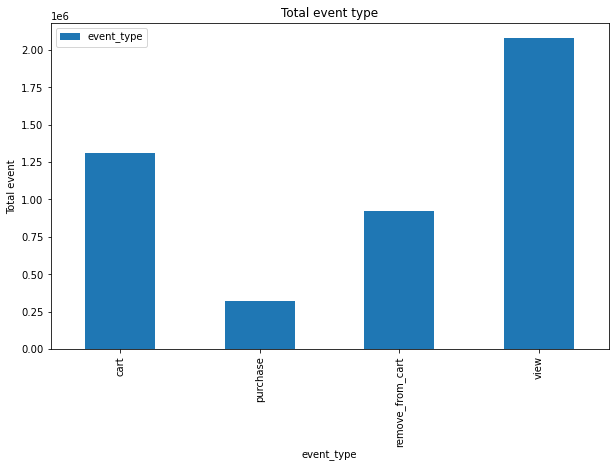

,event_type
event_type,
cart,1311807
purchase,322417
remove_from_cart,925481
view,2076132


In [17]:
plot_numbers=data.groupby("event_type")[["event_type"]].count()

plot_numbers.plot(kind="bar",title='Total event type',
               ylabel='Total event', xlabel='event_type', figsize=(10, 6))
plt.show()
plot_numbers

## Question 6

In [18]:
list_of_view=data[data["event_type"]=="view"].groupby(["user_session","user_id"])["product_id"].apply(list).rename("list_of_view")
list_of_purchased=data[data["event_type"]=="cart"].groupby(["user_session","user_id"])["product_id"].apply(list).rename("list_of_purchased")
list_of_added_to_chart=data[data["event_type"]=="purchase"].groupby(["user_session","user_id"])["product_id"].apply(list).rename("list_of_added_to_chart")
count=data.groupby(["user_session","user_id"])["event_type"].count().rename("count_event")
sum_time=data.groupby(["user_session","user_id"])["duration_to_next_event"].sum().rename("sum_time")
list_of_view,list_of_purchased,list_of_added_to_chart,count,sum_time=list_of_view.to_frame(), list_of_purchased.to_frame(),list_of_added_to_chart.to_frame(),count.to_frame(),sum_time.to_frame()

In [19]:
merge1=pd.merge(list_of_view,list_of_purchased ,on="user_session",how="inner")
merge1=pd.merge(merge1,list_of_added_to_chart ,on="user_session",how="inner")
merge1=pd.merge(merge1,count,on="user_session",how="inner")
merge1=pd.merge(merge1,sum_time,on="user_session",how="inner")
merge2=data.groupby(["user_session","user_id"])["index_in_funnel","funnel_number"].max()
session_data=pd.merge(merge2,merge1,on="user_session",how="inner")

<ipython-input-19-95b382196c6c>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merge2=data.groupby(["user_session","user_id"])["index_in_funnel","funnel_number"].max()


In [20]:
session_data

,index_in_funnel,funnel_number,list_of_view,list_of_purchased,list_of_added_to_chart,count_event,sum_time
user_session,,,,,,,
0002ad82-84d0-40be-8d1a-b48de3ef8fe3,2,1,[5875286],"[5843642, 5815833, 5843634, 5843638, 5843637, ...","[5844306, 5841721, 5844303, 5843837, 5843642, ...",561,0 days 01:59:31
000737df-40bd-46dc-9ab7-96bc4df35719,1,1,"[5767806, 5848909, 5550700, 5747360, 5767004]","[5767806, 5767806, 5550700, 5747360]","[5767806, 5747360, 5550700]",13,0 days 00:32:09
00087855-bf59-4502-a16f-99fdc11fbbfc,50,2,"[5883342, 5885101, 5815785, 5817680, 5833334, ...","[5883343, 5883342, 5823410, 40100, 5560754, 58...","[5824840, 5819229, 5819226, 5819241, 5823410, ...",85,0 days 01:01:00
0009fc62-1478-4563-a3fb-23e7764d49cc,2,1,"[5854294, 38753]","[5569506, 5723406, 5710585, 38753, 5692890, 56...","[5723406, 5759279, 38753, 5890134, 5826601, 57...",65,0 days 00:55:26
00150ced-6ba8-42ba-8f51-f95d7456a968,6,1,[5700037],"[5700037, 5700037, 5700037, 5700037]","[6963, 5857006, 5700037]",10,0 days 00:09:00
...,...,...,...,...,...,...,...
ffef3358-311d-459c-8b6e-391cba0d9f4b,5,1,"[5801303, 5834912, 5826404, 5834912, 5823646, ...","[5823646, 5845350, 5823630, 5823474, 5888550, ...","[5785205, 5809910, 5809912, 5809913, 5823646, ...",86,0 days 00:45:18
fff05250-26c3-462f-9fca-7f3224795716,8,1,[5823410],[5823407],"[5823407, 5763933]",4,0 days 00:06:34
fff1708e-0b21-4417-a776-6db7bdb61585,1,1,"[5820532, 5820532, 5686812, 5820532]","[5820532, 5820532, 5820532, 5820532, 5820532, ...","[5820532, 5686812, 5820527, 5842361, 5820526, ...",26,0 days 00:15:57
